In [1]:
%matplotlib widget
import sys
import pandas as pd
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt
import pickle
from pathlib import Path
from importlib import reload

src = str(Path('../src').resolve())
if src not in sys.path:
    sys.path.append(src)

from evaluate import *

In [311]:
# fig_dir = Path("../runs/flexible_hybrid/_figures")
# exp_dict = {
#     'Time and Basin split': Path("../runs/flexible_hybrid/all_data_20241003_205648"),
#     'Basin_split': Path("../runs/flexible_hybrid/split_basins_20241003_205525"),
#     'Time_split': Path("../runs/flexible_hybrid/split_time_20241003_205528")
# }
# both_color = '#d95f02'
# time_color = '#1b9e77'
# basin_color = '#7570b3'
# line_styles = [(both_color,'-'),(basin_color,'-'),(time_color,'-')]

# # Create custom legend elements
# legend_elements = [
#     mp.lines.Line2D([0], [0], color=both_color, lw=2, label='Time and basin split'),
#     mp.lines.Line2D([0], [0], color=e5_color, lw=2, label='Basin split'),
#     mp.lines.Line2D([0], [0], color=ls_color, lw=2, label='time split'),
# ]


fig_dir = Path("../runs/flexible_hybrid/_figures")
exp_dict = {
    'All Data': Path("../runs/flexible_hybrid/all_data_20241003_205648"),
    'ERA5 & Landsat': Path("../runs/flexible_hybrid/no_static_20241003_205137"),
    'Landsat & Static': Path("../runs/flexible_hybrid/no_era5_20241003_205127"),
    'Landsat only': Path("../runs/flexible_hybrid/landsat_only_20241003_205027"),
    'ERA5 & Static': Path("../runs/flexible_hybrid/no_landsat_20241003_205115"),
    'ERA5 only': Path("../runs/flexible_hybrid/era5_only_20241003_205018"),
    # 'All Data (basin_split)': Path("../runs/flexible_hybrid/split_basins_20241003_205525"),
    # 'All Data (time split)': Path("../runs/flexible_hybrid/split_time_20241003_205528")
}

# Define colors and styles
both_color = '#d95f02'
ls_color = '#1b9e77'
e5_color = '#7570b3'
line_styles = [(both_color,'-'),(both_color,'--'),(ls_color,'-'),(ls_color,'--'),(e5_color,'-'),(e5_color,'--')]

# Create custom legend elements
legend_elements = [
    mp.lines.Line2D([0], [0], color=both_color, lw=2, label='ERA5 & Landsat'),
    mp.lines.Line2D([0], [0], color=e5_color, lw=2, label='ERA5'),
    mp.lines.Line2D([0], [0], color=ls_color, lw=2, label='Landsat'),
    mp.lines.Line2D([0], [0], color=None, lw=0, label=''),
    mp.lines.Line2D([0], [0], color='black', lw=2, linestyle='-', label='With Static'),
    mp.lines.Line2D([0], [0], color='black', lw=2, linestyle='--', label='Without Static')
]



# fig_dir = Path("../runs/swotq/_figures")
# exp_dict = {
#     'ERA5 & SWOT': Path("../runs/swotq/base_config_20240904_161705"),
#     'ERA5 only': Path("../runs/swotq/era5_only_20240904_161802"),
#     'SWOT only': Path("../runs/swotq/swot_only_20240904_161806")
# } 


fig_dir.mkdir(exist_ok=True, parents=True)
            

exp_names = []
results = []
bulk_metrics = []
basin_metrics = []
predict_results = []
for exp_name, exp_dir in exp_dict.items():
    exp_names.append(exp_name)
    with open(exp_dir / "test_data.pkl", 'rb') as f:
        r, bulk_m, basin_m = pickle.load(f)
        
        # for feat in ['usgs_q']:
        for feat in ['ssc','flux','usgs_q']:
            lt10 = basin_m[feat]['num_obs'] < 10
            basin_m.loc[lt10, feat] = np.nan
        
        results.append(r)
        bulk_metrics.append(bulk_m)
        basin_metrics.append(basin_m)
        
    with open(exp_dir / "predict_data.pkl", 'rb') as f:
        r, bulk_m, basin_m = pickle.load(f)
        predict_results.append(r)
        


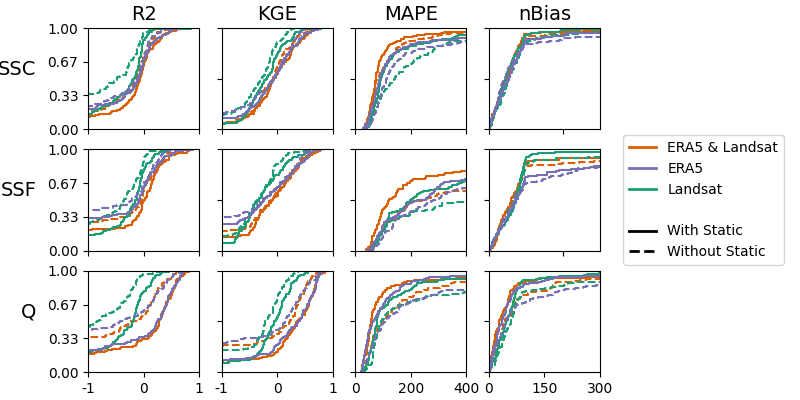

In [325]:
plt.close('all')

metric_args = {
    'R2':{'range':[-1,1]},
    'KGE':{'range':[-1,1]},
    'MAPE': {'range':[0,400]},
    'nBias':{'range':[0,300]}
    }

feature_labels = ['SSC', 'SSF', 'Q']
features = ['ssc', 'flux', 'usgs_q']
nRows = len(features)
nCols = len(metric_args)
fig, axes = plt.subplots(nRows, nCols, figsize=(8, 4))

for feature, axes_row in zip(features, axes):
    for (metric, metric_kwargs), ax in zip(metric_args.items(), axes_row):
        for m, (c, s) in zip(basin_metrics, line_styles):
            if (feature, metric) not in m:
                continue
            x = m[feature, metric].astype(float)
            x = x[np.isfinite(x)]
            
            if 'bias' in metric.lower():
                x = np.abs(x)
                
            ax.ecdf(x, color=c, linestyle=s)
        
        # ax.set_aspect(1./ax.get_data_ratio())
        ax.set_xlim(metric_kwargs['range'])
        ax.set_ylim([0,1])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        
# Top Axes
for (metric, _), ax in zip(metric_args.items(), axes[0,:]):
    ax.set_title(metric, fontsize=14)
    
# Bottom Axes
for ax in axes[-1,:]:
    ax.set_xticks(np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], 3))
    ax.set_xticklabels([int(label) for label in np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], 3)])
    
# Left Axes
for label, ax in zip(feature_labels, axes[:,0]):
    ax.set_ylabel(label, rotation=0, ha='right', fontsize=14, labelpad=8)
    ax.set_yticks(np.linspace(0, 1, 4))
    ax.set_yticklabels([f"{lab:0.2f}" for lab in np.linspace(0, 1, 4)])
    

# Adjust spacing to make room for the legend
plt.subplots_adjust(top=0.93, bottom=0.07, left=0.11, right=0.75)

fig.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(0.77, 0.5))


# fig.tight_layout()
plt.show()

fig.savefig(fig_dir / "ablation_cdfs.png",  dpi=300)

<Axes: >

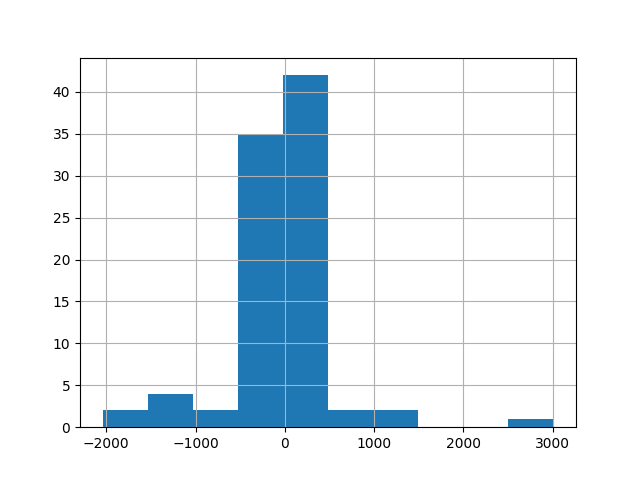

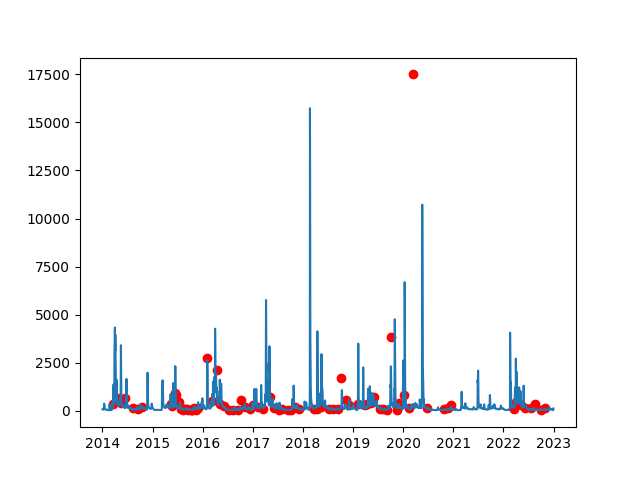

In [66]:
basin_mask  = predict_results[0].index.get_level_values('basin') == 'USGS-04119400'
sorted_df = predict_results[0][basin_mask].sort_values('date')

date = sorted_df.index.get_level_values('date')
plt.close('all')
plt.plot(date, sorted_df['pred']['flux'].values)
plt.scatter(date, sorted_df['obs']['flux'].values,color='r')
plt.show()

In [70]:
sorted_df['dt']['landsat']

basin          date      
USGS-04119400  2014-01-02    95
               2014-01-03    96
               2014-01-04    97
               2014-01-05    98
               2014-01-06    99
                             ..
               2022-12-27    88
               2022-12-28    89
               2022-12-29    90
               2022-12-30    91
               2022-12-31    92
Name: landsat, Length: 3286, dtype: int64

In [ ]:
for preds, color in zip(predict_results, colors):

TypeError: list indices must be integers or slices, not str

In [93]:
basin_metrics[4]

Feature                  ssc                                                   \
Metric               num_obs          R2         MAPE        nBias         RE   
USGS-01125520             70   -3.352101    52.413133    54.820515   1.182379   
USGS-01184000            173    0.115904    539.09806     5.114056   4.257899   
USGS-01349527             74    0.141636    57.551633    70.909813   1.317814   
USGS-01372007             25   -0.246129   122.800556   -76.079163   0.735868   
USGS-01472000             38   -1.387398   173.456787   -49.069489   0.923048   
...                      ...         ...          ...          ...        ...   
USGS-14211720            159 -323.554871  2027.332061 -1754.241211  16.910925   
USGS-14246900            122    0.110297    86.176845     1.130294   0.721095   
USGS-322023090544500     119    0.019213    33.846461    16.095665   0.362066   
USGS-394220106431500      54   -9.529623  1529.820994  -352.121552   5.812046   
USGS-402840107004200      35  -14.313593   149.471107  -183.323807   0.937112   

Feature                                                                \
Metric                         RB         MAE        RMSE       rRMSE   
USGS-01125520         -118.237946   91.479774  103.053307  136.690598   
USGS-01184000          338.509949   33.197533   75.943573  254.786011   
USGS-01349527         -122.974487   52.642494  128.963104  616.543274   
USGS-01372007           56.540848   29.225647    43.68663   72.475525   
USGS-01472000           25.352764   25.213341   43.435848  126.686882   
...                           ...         ...         ...         ...   
USGS-14211720         1691.092529  254.751129   430.05896  159.711044   
USGS-14246900           31.165218   14.095991   26.987734  136.313705   
USGS-322023090544500    -8.941471   66.885941   97.771378   63.205887   
USGS-394220106431500    581.20459   78.524307  158.036697  165.719177   
USGS-402840107004200    74.507866   18.860655   37.671627  153.082581   

Feature                          ...      usgs_q                        \
Metric                      KGE  ...        MAPE       nBias        RE   
USGS-01125520         -0.069653  ...         NaN         NaN       NaN   
USGS-01184000          0.020969  ...   29.444014   16.675558  0.308656   
USGS-01349527         -0.080915  ...   34.012044  -18.023418  0.297523   
USGS-01372007          0.085835  ...         NaN         NaN       NaN   
USGS-01472000           0.02797  ...   74.772526  -70.996658  0.547989   
...                         ...  ...         ...         ...       ...   
USGS-14211720        -21.710573  ...    32.31593    3.948496  0.326148   
USGS-14246900          0.165236  ...   29.948593   23.373325  0.390151   
USGS-322023090544500   0.104301  ...         NaN         NaN       NaN   
USGS-394220106431500  -3.180194  ...  267.020791 -178.087616  2.318462   
USGS-402840107004200  -2.620522  ...         NaN         NaN       NaN   

Feature                                                                 \
Metric                        RB          MAE         RMSE       rRMSE   
USGS-01125520                NaN          NaN          NaN         NaN   
USGS-01184000         -14.393544   149.313889   234.035507   54.522659   
USGS-01349527          10.769725     51.39505    93.745529   53.706562   
USGS-01372007                NaN          NaN          NaN         NaN   
USGS-01472000          51.730942    53.187134    104.02771   90.563354   
...                          ...          ...          ...         ...   
USGS-14211720          -9.529138   272.417358   458.877472   55.198395   
USGS-14246900         -35.426678  1948.330078  2524.845703   48.788109   
USGS-322023090544500         NaN          NaN          NaN         NaN   
USGS-394220106431500  231.846207    25.301224    44.784431  113.414085   
USGS-402840107004200         NaN          NaN          NaN         NaN   

Feature                                             
Metric           

In [265]:
mask.sum()

np.int64(10)

In [274]:
obs = basin_metrics[4]['flux']['num_obs'] > 50
r2 = basin_metrics[4]['flux']['R2'] > 0
kge = basin_metrics[0]['flux']['KGE']> 0.3
nse = basin_metrics[0]['usgs_q']['NSE']> 0.20
mask = obs & r2 & kge# & nse

bias_change = np.abs(basin_metrics[4]['flux']['nBias']) - np.abs(basin_metrics[0]['flux']['nBias'])
basin = bias_change[mask].idxmin()
basin_metrics[0].loc[basin]

Feature  Metric   
ssc      num_obs               91
         R2              0.287175
         MAPE          113.451479
         nBias           -9.26302
         RE              0.902985
         RB             59.877991
         MAE            41.898731
         RMSE           59.383465
         rRMSE          77.922913
         KGE             0.247596
         NSE            -3.805341
         Agreement       0.383783
flux     num_obs               79
         R2              0.281455
         MAPE          693.415512
         nBias         -53.020947
         RE               1.63665
         RB            163.664963
         MAE          4687.896484
         RMSE          6783.40332
         rRMSE          84.061707
         KGE             0.388798
         NSE             0.254949
         Agreement       0.655623
usgs_q   num_obs             1963
         R2             -0.665678
         MAPE           176.32244
         nBias         -79.518486
         RE              1.02

In [ ]:
obs = basin_metrics[0]['flux']['num_obs'] > 50
r2 = basin_metrics[0]['flux']['R2'] > 0
kge = basin_metrics[0]['flux']['KGE']> 0
nse = basin_metrics[0]['usgs_q']['NSE']> 0
mask = obs & r2 & kge & nse

basin = basin_metrics[0][mask]['flux']['NSE'].idxmin()
basin_metrics[0].loc[basin]

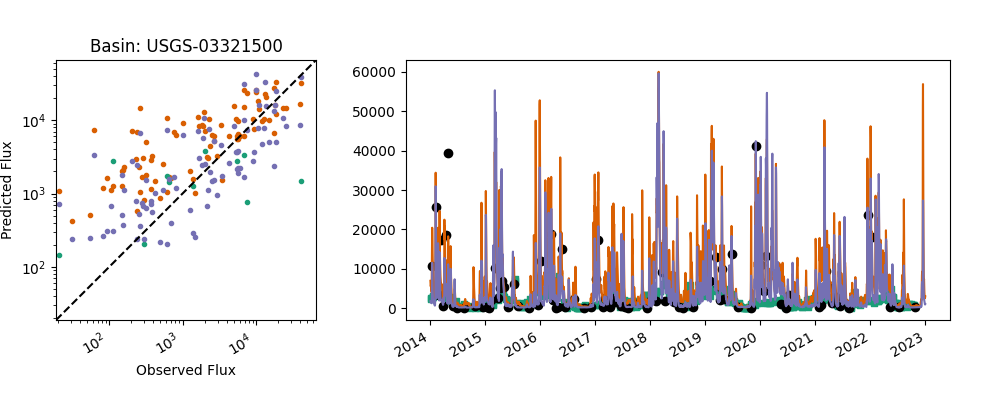

In [275]:
import matplotlib.gridspec as gridspec

"""
USGS-12510500 good improvement in bias.
"""

# Plot the true values and predictions
plt.close('all')

# Create a figure
fig = plt.figure(figsize=(10, 4))

# Create a GridSpec with 1 row and 3 columns
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 0.2, 2])
axes = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 2])]

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

legend_elements = []
mins, maxs = [], []
for preds, name, (c, s) in zip(predict_results, exp_names, line_styles):
    if s == '--':
        continue
    
    basin_mask  = preds.index.get_level_values('basin') == basin
    sorted_df = preds[basin_mask].sort_values('date')
    
    date = sorted_df.index.get_level_values('date')
    values = sorted_df['pred']['flux'].values
    obs = sorted_df['obs']['flux'].values
     
    if not 'era5' in preds['dt'].columns:
        #Remove the predictions with no query basis
        mask = sorted_df['dt']['landsat'] == 0
        date = date[mask]
        values = values[mask]
        obs = obs[mask]
        l = axes[1].scatter(date, values, 15, marker='s', color=c, label=name)#, facecolor='none')
    else:
        l = axes[1].plot(date, values, color=c, label=name)
    legend_elements.append(l)
        
    mins.extend([np.nanmin(values), np.nanmin(obs)])
    maxs.extend([np.nanmax(values), np.nanmax(obs)])
    
    axes[0].scatter(obs, values, marker='.',color=c)
axes[1].scatter(date, obs, color='k')

min_val = float(np.min(mins))*0.9
max_val = float(np.max(maxs))*1.1
axes[0].plot([min_val, max_val], [min_val, max_val], 'k--')

# Setting axes to be square and equal range
axes[0].axis('square')
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_xlim(min_val, max_val)
axes[0].set_ylim(min_val, max_val)
axes[0].set_xlabel(f"Observed Flux")
axes[0].set_ylabel(f"Predicted Flux")
axes[0].set_title(f"Basin: {basin}")


fig.subplots_adjust(top=0.85, left=0.05, right=0.95, wspace=0.05, hspace=0.4)
fig.autofmt_xdate()

plt.show()

# fig.savefig(fig_dir / f"{basin}_timeseries.png",  dpi=300)

In [259]:
legend_elements[1]

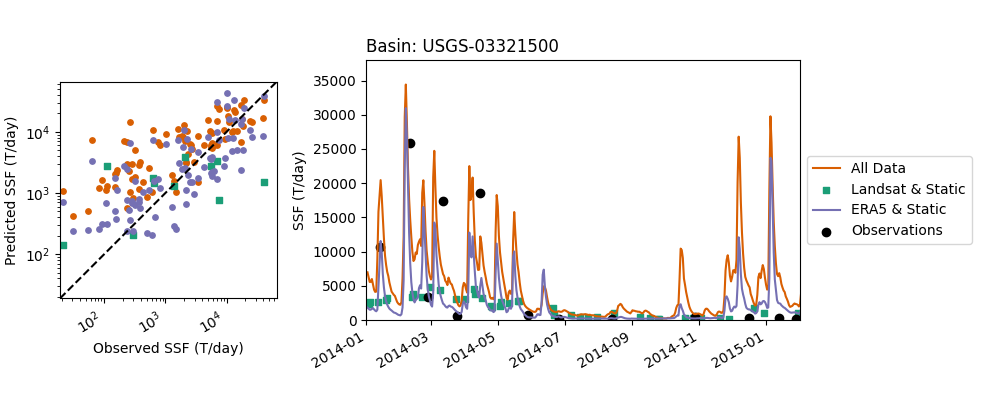

In [326]:
import matplotlib.gridspec as gridspec

"""
good improvement in bias.
basin = 'USGS-12510500'
start_date = np.datetime64('2020-01-01')
end_date = np.datetime64('2022-12-31')
y_max = 6000


basin = 'USGS-03321500'
start_date = np.datetime64('2014-01-01')
end_date = np.datetime64('2015-02-01')
y_max = 38000

"""
basin = 'USGS-03321500'
start_date = np.datetime64('2014-01-01')
end_date = np.datetime64('2015-02-01')
y_max = 38000

# Plot the true values and predictions
plt.close('all')

# Create a figure
fig = plt.figure(figsize=(10, 4))

# Create a GridSpec with 1 row and 3 columns
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 0.2, 2])
axes = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 2])]

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

legend_elements = []
mins, maxs = [], []
for preds, name, (c, s) in zip(predict_results, exp_names, line_styles):
    if s == '--':
        continue
    
    basin_mask  = preds.index.get_level_values('basin') == basin
    sorted_df = preds[basin_mask].sort_values('date')
    
    date = sorted_df.index.get_level_values('date')
    values = sorted_df['pred']['flux'].values
    obs = sorted_df['obs']['flux'].values
     
    if not 'era5' in preds['dt'].columns:
        #Remove the predictions with no query basis
        mask = sorted_df['dt']['landsat'] == 0
        date = date[mask]
        values = values[mask]
        obs = obs[mask]
        axes[0].scatter(obs, values, 15, marker='s',color=c)
        l = axes[1].scatter(date, values, 15, marker='s', color=c, label=name)#, facecolor='none')
        legend_elements.append(l)
    else:
        axes[0].scatter(obs, values, 15, marker='o',color=c)
        l = axes[1].plot(date, values, color=c, label=name)
        legend_elements.append(l[0])
    
    mins.extend([np.nanmin(values), np.nanmin(obs)])
    maxs.extend([np.nanmax(values), np.nanmax(obs)])
    
    
l = axes[1].scatter(date, obs, color='k', label='Observations')
legend_elements.append(l)

min_val = float(np.min(mins))*0.9
max_val = float(np.max(maxs))*1.1
axes[0].plot([min_val, max_val], [min_val, max_val], 'k--')

# Setting axes to be square and equal range
axes[0].axis('square')
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_xlim(min_val, max_val)
axes[0].set_ylim(min_val, max_val)
axes[0].set_xlabel(f"Observed SSF (T/day)")
axes[0].set_ylabel(f"Predicted SSF (T/day)")
axes[1].set_title(f"Basin: {basin}", loc='left')

axes[1].set_xlim(start_date, end_date)
axes[1].set_ylim(0, y_max)
axes[1].set_ylabel("SSF (T/day)")

fig.subplots_adjust(top=0.85, left=0.06, right=0.8, wspace=0.1, hspace=0.4)
fig.autofmt_xdate()


fig.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(0.8, 0.5))


plt.show()

fig.savefig(fig_dir / f"{basin}_zoom_timeseries.png",  dpi=300)

(np.float64(18251.560483320958), np.float64(19351.695188766465))

In [65]:
sorted_df

Type                     obs                         pred                \
Feature                  ssc flux       usgs_q        ssc          flux   
basin         date                                                        
USGS-03378500 2014-01-02 NaN  NaN  3086.536865  67.453316  19589.341797   
              2014-01-03 NaN  NaN  2633.466553  64.762306  17636.117188   
              2014-01-04 NaN  NaN  1973.684570  60.212475  15327.581055   
              2014-01-05 NaN  NaN  1478.139526  56.721058  12270.638672   
              2014-01-06 NaN  NaN  1316.733276  66.769730  14227.675781   
...                       ..  ...          ...        ...           ...   
              2022-12-27 NaN  NaN          NaN  50.360989   2470.022705   
              2022-12-28 NaN  NaN          NaN  44.850471   2109.756592   
              2022-12-29 NaN  NaN          NaN  39.923084   1775.963013   
              2022-12-30 NaN  NaN          NaN  46.533302   2185.932861   
              2022-12-31 NaN  NaN          NaN  60.532944   3388.126709   

Type                                    dt  
Feature                        usgs_q era5  
basin         date                          
USGS-03378500 2014-01-02  2348.711182    0  
              2014-01-03  2171.960449    0  
              2014-01-04  2037.017822    0  
              2014-01-05  1832.051514    0  
              2014-01-06  1842.028687    0  
...                               ...  ...  
              2022-12-27   550.776428    0  
              2022-12-28   523.537048    0  
              2022-12-29   465.516785    0  
              2022-12-30   467.177917    0  
              2022-12-31   584.873352    0  

[3286 rows x 7 columns]

In [ ]:


colors